In [19]:
#import libraries
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from textblob import Word

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from lightgbm import LGBMClassifier

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import pickle
import seaborn as sn

import emoji

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/kalit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
from inltk.inltk import tokenize
from inltk.inltk import setup
setup('hi')

RuntimeError: This event loop is already running

Done!


### Processing Data

In [3]:
# Retrieve data from the given path
filePath = '../../data/hindi/hindi_2021.csv'
df1 = pd.read_csv(filePath,delimiter=',')

df1 = df1.drop('task_2',axis=1)
df1.columns = ['ID','TwitterID','HASOCID','Text','Type']
df1 = df1.drop(['ID','TwitterID','HASOCID'],axis=1)

filePath = '../../data/hindi/hindi_2020.xlsx'
df2 = pd.read_excel(filePath, engine='openpyxl')
df2 = df2.drop(['tweet_id','task2','ID'],axis=1)
df2.columns = ['Text','Type']

filePath = '../../data/hindi/hindi_2019_1.tsv'
df3 = pd.read_csv(filePath,delimiter='\t')
df3 = df3.drop(['text_id','task_2','task_3'],axis=1)
df3.columns = ['Text','Type']

filePath = '../../data/hindi/hindi_2019_2.tsv'
df4 = pd.read_csv(filePath,delimiter='\t')
df4 = df4.drop(['text_id','task_2','task_3'],axis=1)
df4.columns = ['Text','Type']

In [4]:
df = pd.concat([df1,df2,df3,df4])

In [5]:
# Convert target variable to categorical value(integer)

df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df['Type'] = df['Type'].astype(np.int64)

In [6]:
X = df['Text'].values
Y = df['Type'].values

In [7]:
def preprocess(txt):
    '''
        - Convert to lower case
        - Remove excessive spaces
        - Remove @handle
        - Remove website links/URLS
        - Search how to incorporate emojis?
    '''
    txt = str(txt)
    #txt = txt.lower()
    #txt = emoji.demojize(txt)
    txt = re.sub(r'\s+',' ',txt)
    txt = re.sub(r'\n',' ',txt)
    txt = re.sub(r'@[\w\-]+','',txt)
    txt = re.sub(r'https?:\/\/\S+','',txt)
    txt = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)",'',txt)
    #txt = re.sub(r'{link}', '', txt)
    #txt = re.sub(r"\[video\]", '', txt)
    #txt = re.sub(r'&[a-z]+;', '', txt)
    #txt = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', txt)
    #txt = re.sub(r"[^\w\d'\s]+",'',txt)
    return txt

In [8]:
def get_refined_txt(tweet):
    '''
        - Preprocess a given tweet text
        - Tokenize using RegexpTokenizer
        - Lemmatize each token, eg: rocks -> rock, better -> good
        - Remove stop words(or not)?
    '''
    tweet = preprocess(tweet)
    tokens = tokenize(tweet, "hi")
    words = [t for t in tokens]
    refined_txt = ' '.join(words)
    return refined_txt

In [9]:
def generateNGramValues(X_train,X_test):
    count_vect = CountVectorizer(ngram_range=(1, 3), preprocessor=get_refined_txt)
    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.transform(X_test)
    return [X_train_counts,X_test_counts,count_vect]

In [10]:
def generateTFIDFValues(X_train_counts,X_test_counts):
    tf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    X_train_tfidf = tf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tf_transformer.transform(X_test_counts)
    return [X_train_tfidf, X_test_tfidf,tf_transformer]

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

X_train_counts,X_test_counts,count_vect = generateNGramValues(X_train,X_test)
X_train_tfidf, X_test_tfidf,tf_transformer = generateTFIDFValues(X_train_counts,X_test_counts)

In [12]:
def train_classifier(classifier,parameters,cv_fold=5):
    grid_search = GridSearchCV(classifier,param_grid = parameters,
                               cv = StratifiedKFold(n_splits=cv_fold,
                                                random_state=42,shuffle=True).split(X_train_tfidf,Y_train))
    model = grid_search.fit(X_train_tfidf,Y_train)
    evaluate(model,X_test_tfidf,Y_test)    
    return model

In [13]:
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})
    plt.show()

In [14]:
def evaluate(model,X_test,Y_test):
  print('Cross Validation Results:')
  print(model.cv_results_)

  y_pred = model.predict(X_test)
  
  print('Classification Report:')
  report = classification_report(Y_test, y_pred)
  print(report)
  plot_confussion_matrix(Y_test,y_pred)

### Logistic Regression Classifier

Cross Validation Results:
{'mean_fit_time': array([0.271566]), 'std_fit_time': array([0.031974]), 'mean_score_time': array([0.001889]), 'std_score_time': array([3.168675e-05]), 'params': [{}], 'split0_test_score': array([0.70743]), 'split1_test_score': array([0.708814]), 'split2_test_score': array([0.712835]), 'split3_test_score': array([0.702678]), 'split4_test_score': array([0.701293]), 'mean_test_score': array([0.70661]), 'std_test_score': array([0.004196]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1054
           1       0.80      0.73      0.76      1654

    accuracy                           0.72      2708
   macro avg       0.71      0.72      0.72      2708
weighted avg       0.73      0.72      0.73      2708



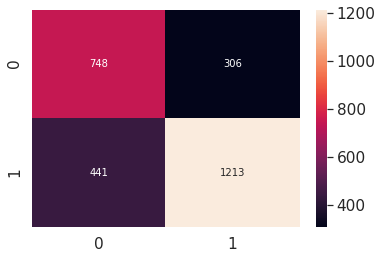

In [20]:
classifier_lr = LogisticRegression(class_weight='balanced',penalty='l2',max_iter=400,
                                solver='liblinear', random_state=42, multi_class='ovr')
classifier_lr = train_classifier(classifier_lr,parameters=[{}],cv_fold=5)

### Support Vector Classifier

Cross Validation Results:
{'mean_fit_time': array([11.895743, 13.08152 , 12.015115, 13.993471, 14.890092, 14.859613, 12.349486, 15.50662 , 13.634326, 26.507307,
       12.496443, 30.096939]), 'std_fit_time': array([0.373642, 0.325401, 0.5374  , 0.615245, 0.430747, 0.395327, 0.487266, 0.476035, 0.572931, 2.460265, 0.603192,
       0.673639]), 'mean_score_time': array([2.604289, 2.67475 , 2.679598, 2.954498, 2.951244, 3.049229, 2.883419, 3.299741, 2.831747, 3.339268, 2.6473  ,
       2.962153]), 'std_score_time': array([0.084087, 0.087756, 0.165594, 0.15887 , 0.123415, 0.073286, 0.185059, 0.077554, 0.139378, 0.110985, 0.109648,
       0.048012]), 'param_C': masked_array(data=[0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1, 0.1, 10, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.01, 0.1, 'auto', 'scale', 0.01, 0.1, 'auto', 'scale', 0.01, 0.

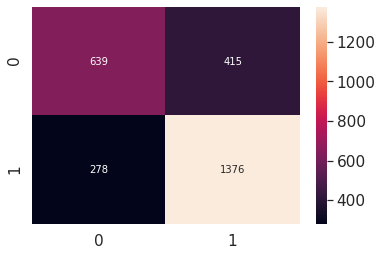

In [15]:
classifier_svc = SVC(kernel='rbf')
params = {'C':[0.001,0.1,10],'gamma':[0.01,0.1,'auto','scale']}
classifier_svc = train_classifier(classifier_svc,parameters=params,cv_fold=5)

### Random Forest Classifier

Cross Validation Results:
{'mean_fit_time': array([ 43.127808,  96.10929 , 201.431373,  50.1225  , 103.843129, 197.720567]), 'std_fit_time': array([ 1.629865,  4.505334, 11.054193,  1.429419,  5.854367,  9.512275]), 'mean_score_time': array([0.338612, 0.721454, 1.470496, 0.087005, 0.170012, 0.346463]), 'std_score_time': array([0.017518, 0.025057, 0.044261, 0.005604, 0.003122, 0.012695]), 'param_max_features': masked_array(data=['log2', 'log2', 'log2', 'sqrt', 'sqrt', 'sqrt'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 'log2', 'n_estimators': 50}, {'max_features': 'log2', 'n_estimators': 100}, {'max_features': 'log2', 'n_estimators': 200}, {'max_features': 'sqrt', 'n_estimators': 50}, {'max_features': 'sqrt', 'n_

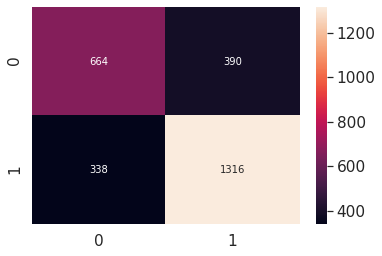

In [21]:
classifier_rf = RandomForestClassifier()
params = {'n_estimators':[50,100,200],'max_features':['log2','sqrt']}
classifier_rf = train_classifier(classifier_rf,parameters=params,cv_fold=5)

### XGBoost Classifier

Cross Validation Results:
{'mean_fit_time': array([451.043492]), 'std_fit_time': array([37.767704]), 'mean_score_time': array([0.352492]), 'std_score_time': array([0.011515]), 'params': [{}], 'split0_test_score': array([0.699123]), 'split1_test_score': array([0.704661]), 'split2_test_score': array([0.697138]), 'split3_test_score': array([0.691136]), 'split4_test_score': array([0.696214]), 'mean_test_score': array([0.697654]), 'std_test_score': array([0.004384]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1054
           1       0.75      0.80      0.77      1654

    accuracy                           0.71      2708
   macro avg       0.70      0.69      0.69      2708
weighted avg       0.71      0.71      0.71      2708



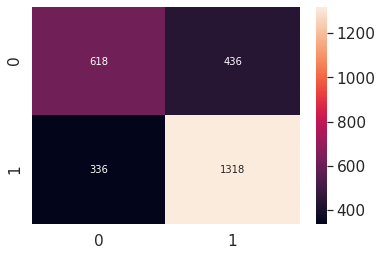

In [17]:
classifier = LGBMClassifier(learning_rate=0.05,n_estimators=1500,
                            colsample_bytree= 0.5,metric = 'f1_score')
train_classifier(classifier,parameters=[{}],cv_fold=5)

### Predicting outputs

In [16]:
filePath = '../../data/hindi/hi_Hasoc2021_test_task1.csv'

In [17]:
def get_predictions(filePath,model,output_file):
    df_test = pd.read_csv(filePath,delimiter=',')
    
    results = {}

    for ind in df_test.index:
        txt = df_test['text'][ind]
        id = df_test['tweet_id'][ind]

        txt = get_refined_txt(txt)
        txt_cnt = count_vect.transform([txt])
        txt_tfidf = tf_transformer.transform(txt_cnt)

        output = model.predict(txt_tfidf)

        if(output[0]==0):
          results[id] = "HOF"
        else:
          results[id] = "NOT"
        
    df_results = pd.DataFrame(list(results.items()))
    df_results.columns = ["id","label"]
    df_results.to_csv(output_file,index=False)

In [25]:
output_file_path = "../../data/hindi/classifier_tfidf_ngram_approach_hindi_lr_28Aug.csv"
get_predictions(filePath,classifier_lr,output_file_path)

In [18]:
output_file_path = "../../data/hindi/classifier_tfidf_ngram_approach_hindi_svc_30Aug.csv"
get_predictions(filePath,classifier_svc,output_file_path)

In [22]:
output_file_path = "../../data/hindi/classifier_tfidf_ngram_approach_hindi_rf_30Aug.csv"
get_predictions(filePath,classifier_rf,output_file_path)

### Saving models

In [28]:
import joblib

In [35]:
filename = '../../data/hindi/classifier_tfidf_ngram_approach_hindi_lr.pkl'
joblib.dump(classifier_lr, filename)

TypeError: can't pickle generator objects

In [36]:
filename = '../../data/hindi/classifier_tfidf_ngram_approach_hindi_svc.pkl'
joblib.dump(classifier_svc, filename)

TypeError: can't pickle generator objects

In [37]:
filename = '../../data/hindi/classifier_tfidf_ngram_approach_hindi_rf.pkl'
joblib.dump(classifier_rf, filename)

TypeError: can't pickle generator objects